# Sentiment Analysis on Amazon Product Reviews of Sensitive Toothpastes
- Part 1. Data Exploration and Preparation
- Part 2. Unsupervised Sentiment Analysis: TextBlob, Vader
- Part 3. Supervised Sentiment Analysis: Word2Vec

## Part 1. Data Exploration and Preparation

In [375]:
import gensim
from gensim.models import Word2Vec

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from textblob import TextBlob    # import textblob packages, nlp
from textblob.sentiments import NaiveBayesAnalyzer
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# import natural language toolkit
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Yuting.Gong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Load Data

In [250]:
df = pd.read_csv("C:/Users/Yuting.Gong/Desktop/CodeBox/data/AmaonProductReview/amazon_reviews_US_forWeb.csv", dtype={'review_text': str})
df.head()

,average_product_rating,product_title,product_url,review_date,review_id,review_rating,review_title,sku,upvotes,url,Sensitive,Brand,Sub-Brand,Ingredient,Category,review_text
0,4.3,"Colgate Sensitive Maximum Strength Toothpaste,...",https://www.amazon.com/Colgate-Sensitive-Stren...,"May 8, 2017",R388T3PPGR3KTV,2,Soso,B0053XLIN2,0.0,https://www.amazon.com/gp/customer-reviews/R38...,1.0,Colgate,Sensitive Maximum,0,TP,"Just clean,I want white product,it can't white..."
1,4.3,"Colgate Sensitive Maximum Strength Toothpaste,...",https://www.amazon.com/Colgate-Sensitive-Stren...,"April 29, 2017",R3CSQJHAH3D8PQ,5,Five Stars,B0053XLIN2,0.0,https://www.amazon.com/gp/customer-reviews/R3C...,1.0,Colgate,Sensitive Maximum,0,TP,Great
2,4.3,"Colgate Sensitive Maximum Strength Toothpaste,...",https://www.amazon.com/Colgate-Sensitive-Stren...,"April 26, 2017",R2PVX8G4WVQYTI,5,Five Stars,B0053XLIN2,0.0,https://www.amazon.com/gp/customer-reviews/R2P...,1.0,Colgate,Sensitive Maximum,0,TP,this works great for my sensitive teeth!
3,4.3,"Colgate Sensitive Maximum Strength Toothpaste,...",https://www.amazon.com/Colgate-Sensitive-Stren...,"April 25, 2017",RBOXB3P3O6JAL,4,Four Stars,B0053XLIN2,0.0,https://www.amazon.com/gp/customer-reviews/RBO...,1.0,Colgate,Sensitive Maximum,0,TP,I like it
4,4.3,"Colgate Sensitive Maximum Strength Toothpaste,...",https://www.amazon.com/Colgate-Sensitive-Stren...,"April 20, 2017",R2YQSP98YTZ457,5,Five Stars,B0053XLIN2,0.0,https://www.amazon.com/gp/customer-reviews/R2Y...,1.0,Colgate,Sensitive Maximum,0,TP,Nice


The text column is "review_text". The target column is "review_rating".

In [218]:
column = "review_text"

### Data Summary

In [251]:
print("Summary statistics of numerical data")
print(df.describe())

print("\nTotal number of reviews", df.shape[0])

def rating_sentiment(rating):
    if rating >= 4:
        return "Positive"
    elif rating == 3:
        return "Neutral"
    else:
        return "Negative"
df["rating_sentiment"] = df["review_rating"].apply(rating_sentiment)
print("\nRatio of Positive vs. Neutral vs. Negative Review Sentiment : (all in percentage)")
print(df["rating_sentiment"].value_counts()/df.shape[0] * 100)

Summary statistics of numerical data
       average_product_rating  review_rating       upvotes     Sensitive
count            25716.000000   25716.000000  22785.000000  25630.000000
mean                 4.363354       4.400101      0.879175      0.229926
std                  0.314337       1.099385     11.099193      0.420793
min                  1.000000       1.000000      0.000000      0.000000
25%                  4.200000       4.000000      0.000000      0.000000
50%                  4.500000       5.000000      0.000000      0.000000
75%                  4.600000       5.000000      0.000000      0.000000
max                  5.000000       5.000000    815.000000      1.000000

Total number of reviews 25716

Ratio of Positive vs. Neutral vs. Negative Review Sentiment : (all in percentage)
Positive    85.262094
Negative     8.481101
Neutral      6.256805
Name: rating_sentiment, dtype: float64


### Data Visualization

#### Distribution of Review Rating
We clearly have a lot more positive ratings than negative ones.

Text(0, 0.5, 'Count')

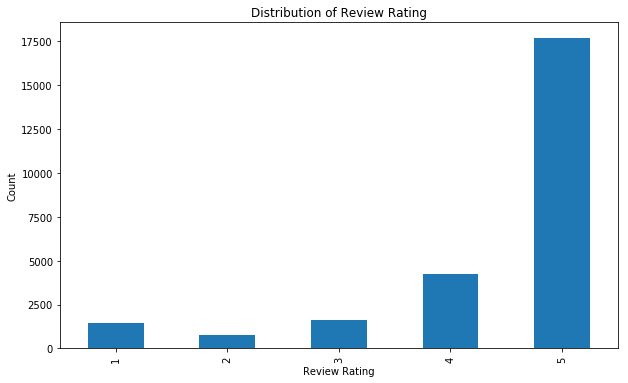

In [252]:
plt.figure(figsize = (10,6))
df["review_rating"].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Rating')
plt.xlabel('Review Rating')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

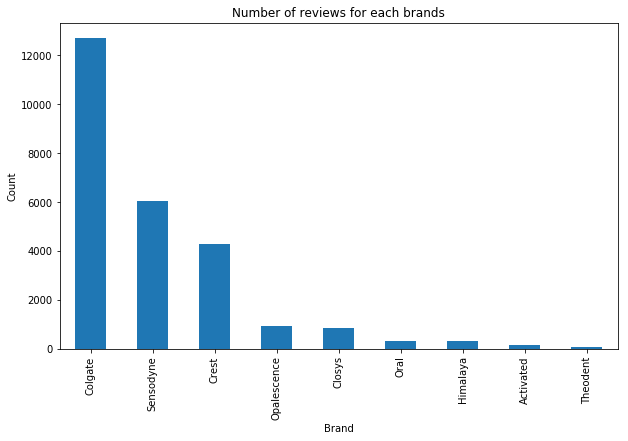

In [253]:
# number of reviews for each brands
plt.figure(figsize = (10,6))
df["Brand"].value_counts().plot(kind='bar')
plt.title('Number of reviews for each brands')
plt.xlabel('Brand')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

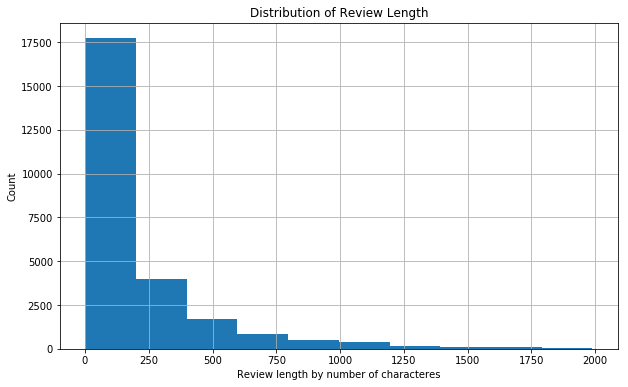

In [254]:
# Review Length
length = df["review_text"].dropna().apply(lambda x: len(x))
plt.figure(figsize = (10,6))
length.loc[length < 2000].hist()
plt.title("Distribution of Review Length")
plt.xlabel('Review length by number of characteres')
plt.ylabel('Count')

### Data Preparation

One of the major problem with the data are duplications. Some reviews got duplicated for the same products but in different packages or sizes. During the unsupervised sentiment analysis, duplicates do not influence analysis. However, duplications will be a problem during supervised sentiment analysis as duplications will influence Word2Vec model building. Thus, I will prepare two sets of data. In the unsupervised sentiment analysis, I will only remove NA. In the supervised sentiment analysis, I will keep the first occurance of each reviews, and remove the rest of duplicates. If reviews are duplicated for different products, I will treat it as wrong data and remove them as well. 

In [255]:
# Drop missing reviews
df = df.dropna(subset= [column])

# For supervised learning, drop duplicates
dup = df[df.duplicated(subset = "review_id", keep = False)].copy()

# remove 129 reviews where the same review_id have different sub-brands
a = pd.DataFrame(dup.groupby(["review_id"])["Sub-Brand"].nunique())
a = a.reset_index()
remove_id = a[a["Sub-Brand"] > 1]["review_id"].to_list()
newdf = df[~df["review_id"].isin(remove_id)].copy()

# remove other duplicates
newdf = newdf[newdf.duplicated(subset = ["review_id"]) == False]

In [256]:
newdf.head()

,average_product_rating,product_title,product_url,review_date,review_id,review_rating,review_title,sku,upvotes,url,Sensitive,Brand,Sub-Brand,Ingredient,Category,review_text,rating_sentiment
170,4.5,Colgate Sensitive Prevent and Repair Toothpast...,https://www.amazon.com/Colgate-Sensitive-Preve...,"March 16, 2017",R2734240DSBM1J,5,Five Stars,B00IAH0PYG,0.0,https://www.amazon.com/gp/customer-reviews/R27...,1.0,Colgate,CSPR,0,TP,ok,Positive
171,4.5,Colgate Sensitive Prevent and Repair Toothpast...,https://www.amazon.com/Colgate-Sensitive-Preve...,"December 16, 2016",R9156LCLWHDIX,5,Five Stars,B00IAH0PYG,0.0,https://www.amazon.com/gp/customer-reviews/R91...,1.0,Colgate,CSPR,0,TP,Like the clean taste and feel of this toothpaste.,Positive
172,4.5,Colgate Sensitive Prevent and Repair Toothpast...,https://www.amazon.com/Colgate-Sensitive-Preve...,"November 28, 2016",R3PY8VWKVFJQEO,2,Two Stars,B00IAH0PYG,0.0,https://www.amazon.com/gp/customer-reviews/R3P...,1.0,Colgate,CSPR,0,TP,It's just OK - I would rank it behind the othe...,Negative
173,4.5,Colgate Sensitive Prevent and Repair Toothpast...,https://www.amazon.com/Colgate-Sensitive-Preve...,"November 19, 2016",RGQVXWQ6U7UQ5,5,Five Stars,B00IAH0PYG,0.0,https://www.amazon.com/gp/customer-reviews/RGQ...,1.0,Colgate,CSPR,0,TP,Works great,Positive
174,4.5,Colgate Sensitive Prevent and Repair Toothpast...,https://www.amazon.com/Colgate-Sensitive-Preve...,"October 21, 2016",R1C1ZD2HZWWZT1,5,My new favorite toothpaste,B00IAH0PYG,0.0,https://www.amazon.com/gp/customer-reviews/R1C...,1.0,Colgate,CSPR,0,TP,"My dentist recommended this toothpaste, and I ...",Positive


In [411]:
newdf.shape

(15958, 17)

## Part 2. Unsupervised Sentiment Analysis
Unlike this amazon product review dataset, often times text reviews do not have sentiment labels. We might obtain the reviews from social media directly about certain products and want to use sentiment analysis to understand consumers' emotions. Here is when unsupervised sentiment analysis comes in. Unsupervised learning involves using a rule-based approach to analyze a comment. There are a few pre-built libraries for sentiment analysis. I picked two major lexical-based approaches: TextBlob and VADER, which are also open source and free. We can compare to see which one is more accurate for our dataset.

### 1. TextBlob sentiment analysis

TextBlob is a Python-based open source NLP library that has a built-in sentiment analysis function. Its sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0], with 1 being the most positive and 0 being the most negative. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. Here I focus on getting the polarity which is the sentiment.

In [258]:
# make functions to detect the polarity
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [259]:
# execution

df['textblob_polarity'] = df[column].apply(detect_polarity)

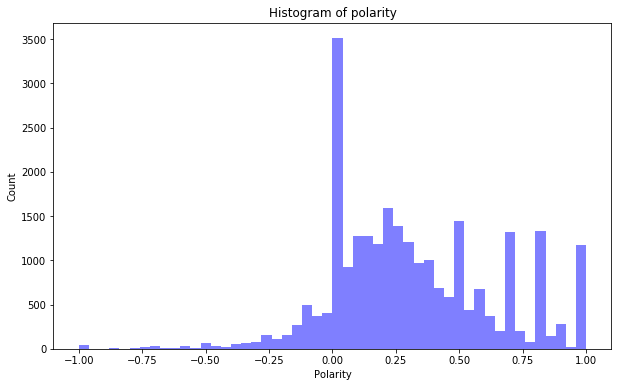

In [373]:
# check the distribution of polarity

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.textblob_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

### 2. Vader Sentiment Analysis

VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. A sentiment lexicon is a list of lexical features (e.g., words) which are generally labeled according to their semantic orientation as either positive or negative. VADER not only tells about the Positivity and Negativity score but also tells us about how positive or negative a sentiment is.

The Compound score is a metric that calculates the sum of all the lexicon ratings which have been normalized between -1(most extreme negative) and +1 (most extreme positive).

Below cut-off is suggested by VADER:

positive sentiment : (compound score >= 0.05)

neutral sentiment : (compound score > -0.05) and (compound score < 0.05)

negative sentiment : (compound score <= -0.05)

In [263]:
# --- examples -------
sentences = ["I'm very happy."]

analyzer = SentimentIntensityAnalyzer()

for sentence in sentences:
    vs = analyzer.polarity_scores(sentence)
    print("{:-<65} {}".format(sentence, str(vs)))

I'm very happy.-------------------------------------------------- {'neg': 0.0, 'neu': 0.334, 'pos': 0.666, 'compound': 0.6115}


In [262]:
# create function to use Vader to detect sentiment
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(text):
    return analyzer.polarity_scores(text)['compound']

# execution
df['vader_polarity'] = df[column].apply(vader_sentiment)

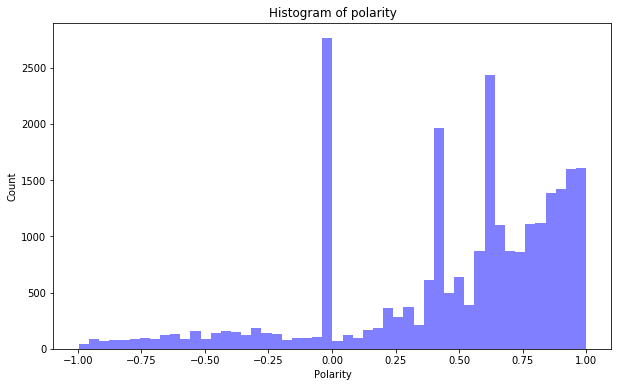

In [264]:
# check distribution of vender's sentiment results

num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.vader_polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show();

## Part 3. Supervised Sentiment Analysis
In supervised sentiment analysis, the goal is to use machine learning methods to classify the review_texts into positive, neutral or negative sentiments. In order to feed the review data to a machine learning algorithm, we need to represent the texts in a numercial form. I chose to use Word2Vec word embedding because it is one of the most popular word embeddings to represent document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

In addition to being a multi-class classificatin, it is also noteworthy that the amazon data  here is a very imbalanced dataset. About 84% of the reviews are positive while there are only 9% negative reviews and 7% neutral reviews. So to evaluate the accuracy of the classification, I decided to use Precesion, Recall and F1 score instead of just Accuracy.


In this part, I will first preprocess the texts and then use gensim library to train a Word2Vec model to create vector word representations. Then, I will calculate the average vector for each reviews and fit them to machine learning algorithms. 


__Workflow of this part:__
- Clean and Normalize reviews (tokenization)
- Word2Vec: Preprocess reviews and transform review words to vectors using Word2Vec
- Compute average vectors for each reviews
- Fit average vectors to supervised learning algorithm 

#### Clean and Normalize reviews, tokenization
We need to remove punctuations and leaves only alphabetic character. We also want to lower the case of words. As to get Word2Vec we need tokens(word), I will also split into words. Also to simply the problem, I will keep only positive and negative sentiments.

In [296]:
def clean(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ", raw_text)  # remove non-character
    words = letters_only.lower().split() # convert to lower case 
    
    return( " ".join(words))

In [390]:
df2 = newdf[newdf['rating_sentiment'] != "Neutral"].copy()

In [391]:
data2 = df2['review_text']
clean_review2 = []
for document in data2:
    clean_review2.append(clean(document))
tokens2 = []
for review in clean_review2:
    tokens2.append(review.split())
print("An example:",  clean_review2[4])
print("An example:", tokens2[4])

An example: my dentist recommended this toothpaste and i really like it pleasant flavor and makes your mouth feel clean
An example: ['my', 'dentist', 'recommended', 'this', 'toothpaste', 'and', 'i', 'really', 'like', 'it', 'pleasant', 'flavor', 'and', 'makes', 'your', 'mouth', 'feel', 'clean']


### Word2Vec: Preprocess reviews and transform review words to vectors using Word2Vec

Gensim’s word2vec expects a sequence of sentences as its input, each one as a list of words. So I will first split reviews into sentences and then tokenize them into words.

#### Split corpus into individual sentences

In [304]:
# Convert all the review text into a long string and print its length
raw_corpus = "".join(newdf['review_text']+" ")
print("Raw Corpus contains {0:,} characters".format(len(raw_corpus)))

tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
# we tokenize the raw string into raw sentences
raw_sentences = tokenizer.tokenize(raw_corpus)
print("We have {0:,} raw sentences".format(len(raw_sentences)))

Raw Corpus contains 4,067,783 characters
We have 52,045 raw sentences


In [305]:
def clean_and_split_str(string):
    strip_special_chars = re.compile("[^A-Za-z]+")
    string = re.sub(strip_special_chars, " ", string)
    return string.strip().lower().split()
     
# clean each raw sentences and build the list of sentences
sentences = []
for raw_sent in raw_sentences:
    if len(raw_sent) > 0:
        sentences.append(clean_and_split_str(raw_sent))
print("We have {0:,} clean sentences".format(len(sentences)))
print("An example of a sentence:", sentences[3])

We have 52,045 clean sentences
An example of a sentence: ['pleasant', 'flavor', 'and', 'makes', 'your', 'mouth', 'feel', 'clean']


In [306]:
token_count = sum([len(sentence) for sentence in sentences])
print("The dataset corpus contains {0:,} tokens".format(token_count))

The dataset corpus contains 756,248 tokens


#### Train a Word2Vec Model

In [308]:
import multiprocessing

#Dimensionality of the resulting word vectors
num_features = 300
 
#Minimum word count threshold
min_word_count = 3
 
#Number of threads to run in parallel
num_workers = multiprocessing.cpu_count()
 
#Context window length
context_size = 7
 
#Seed for the RNG, to make the result reproducible
seed = 1

In [318]:
word2vec_model = Word2Vec(sentences = sentences,
    sg=1,
    seed=seed,
    workers=num_workers, 
    size=num_features, 
    min_count=min_word_count, 
    window=context_size)
     
print("The vocabulary is built")
print("Word2Vec vocabulary length: ", len(word2vec_model.wv.index2word))

The vocabulary is built
Word2Vec vocabulary length:  5469


In [340]:
word2vec_model.save("amazon.model")

# model = Word2Vec.load("amazon.model")

C:\Users\Yuting.Gong\AppData\Local\Continuum\anaconda3\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


#### Compute average vectors for each reviews
Now we have a vector for each vocabulary. But in order to get a vector for a reveiw, we need to further processing. I chose to take an average vector of all words in a review as the vector of a review.

In [344]:
def averageVector(reviews, w2v):
    total = []
    lst = w2v.wv.index2word
    for review in reviews:
        avgVector = w2v.wv['i']*0
        count = 0
        empty = True
        for word in review:
            if word in lst:
                count += 1
                avgVector = np.add(avgVector, w2v.wv[word])
                empty = False
        if not empty:
            avgVector = np.divide(avgVector, count)
        total.append(avgVector)
    return total

In [392]:
allVectors2 = averageVector(tokens2, word2vec_model)

In [393]:
len(allVectors2)

14852

## Train Test Split

In [394]:
y2 = df2["rating_sentiment"]
X_train2, X_test2, y_train2, y_test2 = train_test_split(pd.DataFrame(allVectors2), y2, test_size=0.2, random_state=42, stratify = y2)

# Fit average vectors to supervised learning algorithm:
## SVM Classifier as a baseline model
Clearly, SVM is not a good model for this problem. Its precision for positive class is very high but the precision for negative sentiments are super low.

In [398]:
svm2 = SVC(gamma='auto', class_weight = 'balanced')
svm2.fit(X_train2, y_train2) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [399]:
y_pred_svm2 = svm2.predict(X_test2)

In [400]:
accuracy_score(y_test2, y_pred_svm2)

0.5435880175025244

In [401]:
print(classification_report(y_test2, y_pred_svm2))

              precision    recall  f1-score   support

    Negative       0.17      0.97      0.29       287
    Positive       0.99      0.50      0.66      2684

   micro avg       0.54      0.54      0.54      2971
   macro avg       0.58      0.73      0.48      2971
weighted avg       0.91      0.54      0.63      2971



# Random Forest Classifier

In [395]:
# Random Forest Classifier
rf2 = RandomForestClassifier(n_estimators=100)
rf2.fit(X_train2, y_train2)
y_pred_rf2 = rf2.predict(X_test2)

In [396]:
accuracy_score(y_test2, y_pred_rf2)

0.9205654661730057

In [397]:
print(classification_report(y_test2, y_pred_rf2))

              precision    recall  f1-score   support

    Negative       0.87      0.21      0.34       287
    Positive       0.92      1.00      0.96      2684

   micro avg       0.92      0.92      0.92      2971
   macro avg       0.90      0.60      0.65      2971
weighted avg       0.92      0.92      0.90      2971



# XGBoost

In [406]:
xgb_2 = XGBClassifier(n_estimators=600, objective= 'multi:softprob',learning_rate=0.05, max_depth=5, min_child_weight=3, num_class=2)

In [407]:
xgb_2.fit(X_train2, y_train2)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.05,
       max_delta_step=0, max_depth=5, min_child_weight=3, missing=None,
       n_estimators=600, n_jobs=1, nthread=None, num_class=2,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1)

In [408]:
y_pred2 = xgb_2.predict(X_test2)
accuracy_score(y_test2, y_pred2)

0.9289801413665433

In [410]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

    Negative       0.75      0.40      0.52       287
    Positive       0.94      0.99      0.96      2684

   micro avg       0.93      0.93      0.93      2971
   macro avg       0.84      0.69      0.74      2971
weighted avg       0.92      0.93      0.92      2971



### XGBoost was better than Random Forest Classifier as it reached a 93% accuracy, and 92% weighted average F1 score, higher than random forest's 90% F1 score